In [1]:
# Random to intialize random perceptron weights (if required)
# Numpy for vectors,matrices and dot products
import random as rd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline  

In [239]:


#-------------------------------------------------------------------------------------------------------#
# Defining a perceptron

class linearPerceptron(object):
    
    def __init__(self, num_inputs, weight_vector = None):
        # Defining the initial perceptron
        self.num_inputs = num_inputs
        if(weight_vector is None):
            self.weights = [rd.random() for i in range(num_inputs)]
        else:
            if(len(weight_vector) != num_inputs):
                raise Exception("Weight vector size invalid. Must be #Inputs + 1")
            else:
                self.weights = weight_vector
        self.weights = np.array(self.weights)
        self.output = None
        self.iterError = np.array([])
        self.weightUpdates = None  
        self.minError = None
        self.runIters = 0
        self.converged = 0
    
    def computePerceptronOutput(self, input_vector):
        # Computes the output as a combination of inputs
        if(input_vector is not np.array):
            input_vector = np.array(input_vector)

        if(self.weights.size == input_vector.size):   
            self.output = np.dot(self.weights, input_vector)
        else:
            print "Inputs provided is of invalid size"
                
        return self.output
    
                
    def computeError(self,input_matrix, target_vector, custom_weights = None):
        # Compute errors in the current weight training
        
        nTrain = len(input_matrix)
        oldWeights = self.weights
        
        if(custom_weights is not None):
            if(len(custom_weights) != self.num_inputs):
                raise Exception("Weight vector size invalid. Must be #Inputs")
            else:
                self.weights = np.array(custom_weights)

        outputVector = [self.computePerceptronOutput(input_vector) for input_vector in input_matrix]
        
        if(len(target_vector) != nTrain):
            raise Exception("Training Vector provided is not of the same size as inputs")

        error_vector = np.subtract(target_vector,outputVector)
        error_squared = [x * x for x in error_vector]
        totalError = sum(error_squared) * 0.5
        updateSize = np.dot(error_vector,input_matrix)
        
        self.weights = oldWeights
        
        return totalError,updateSize
    
    
    def trainGradientDescent(self, input_matrix, target_vector, alpha = 0.01, nIter = 100, method = "batch", nsample = None):
        
        
        # Batch Gradient Descent is performed on the linear Perceptron given
        # the input matrix and a target vector to be learnt at learning Rate (alpha)
        # The batch descent is by default set to run only 100 iterations
        # Samples are picked every iteration to avoid gradient descent happening 
        # in the same direction every time
            
        if(method=="batch"):
            print "Training with Batch Gradient Descent....! Plz Wait..!"

            # Input matrix is number_of_inputs X no. of training examples

            self.weightUpdates = np.array(self.weights,ndmin = 2)

            nInput = self.num_inputs

            self.minError,updateSizes = self.computeError(input_matrix = input_matrix,target_vector = target_vector)
            self.iterError = np.append(self.iterError,self.minError)

            for i in range(nIter):

                totalError,updateSizes = self.computeError(input_matrix,target_vector)

                deltaWeights = alpha * updateSizes

                # UpdateWeights
                oldWeights = self.weights
                newWeights = np.add(self.weights,deltaWeights)
                self.weights = newWeights

                totalError,updateSizes = self.computeError(input_matrix,target_vector)

                if(totalError >= self.minError):
                    self.converged = 1
                    self.runIters = i
                    self.weights = oldWeights
                    print "Converged.....!"
                    print self.weights
                    return
                else:
                    self.minError = totalError
                    self.weights = newWeights
                    self.weightUpdates = np.append(self.weightUpdates,[self.weights],axis = 0)
                    self.iterError = np.append(self.iterError,self.minError)


            print "Ran out of iterations without converging......! Tough luck matey...!"
            print self.weights
    
        # For stochastic gradient descent
        elif(method == "stochastic"):
            
            print "Training with Stochastic Gradient Descent....! Plz Wait..!" 
            
            self.weightUpdates = np.array(self.weights,ndmin = 2)

            nInput = self.num_inputs
            nTrain = len(input_matrix)
            
            self.minError,updateSizes = self.computeError(input_matrix = input_matrix,target_vector = target_vector)
            self.iterError = np.append(self.iterError,self.minError)
            
            oldWeights = self.weights
            
            # Run through iterations
            for i in range(nIter):
                
                if(nsample is None):
                    inputSubset = input_matrix
                elif((nsample < nTrain)):
                    sample_trn = np.random.randint(0,nTrain,nsample)
                    inputSubset = input_matrix[sample_trn]
                else:
                    print "Data type wrong size or invalid for sample size"
                    
                # Run through all training examples
                for j in range(len(inputSubset)):
                    
                    input_vector = input_matrix[j]
                    current_output = target_vector[j]
                    
                    newWeights = self.weights
                    
                    self.computePerceptronOutput(input_vector)
                    deltaWeights = alpha * (current_output - self.output) * input_vector

                    newWeights = np.add(newWeights,deltaWeights)
                    
                    self.weights = newWeights

                totalError,updateSizes = self.computeError(input_matrix,target_vector)

                if(totalError > self.minError):
                    self.converged = 1
                    self.runIters = i
                    self.weights = oldWeights
                    self.minError = totalError
                    # self.iterError = np.append(self.iterError,totalError)
                    # self.weightUpdates = np.append(self.weightUpdates,[self.weights],axis = 0)
                    print "Converged.....!"
                    print self.weights
                    return

                else:
                    self.minError = totalError
                    self.weightUpdates = np.append(self.weightUpdates,[self.weights],axis = 0)
                    self.iterError = np.append(self.iterError,self.minError)

                    
            print "Ran out of iterations without converging......! Tough luck matey...!"
            print self.weights
        
        
        else:
            
            print "No valid method provided...! Must be either 'stochastic' or 'batch'"
#----------------------------------------------------------------------------------------------#

In [33]:
# Function plots the error surface currently. Will be extended to plot iteration errors for the model
# Plan is to add the iteration errors for validation set as well
def surfaceErrorPlot(linearPerceptronObject,input_matrix,target_vector,breaks = 200):
    # Method prints all possible plots for the neural network
    # Includes Error surface plots, Iteration errors
    
    lpTest = linearPerceptronObject
    
    print "Output Plots using matplotlib"
    
    # Creating mesh for plotting error surface
    weightTest = [x * 0.01 for x in range(-breaks/2,breaks/2)]
    w0,w1 = np.meshgrid(weightTest,weightTest)
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    customWeights = [[w0[0][i],w1[0][i]] for i in range(breaks)]
    errorValues = [linearPerceptronObject.computeError(input_matrix,target_vector,custom_weights = x)[0] for x in customWeights]
    surf = ax.plot_surface(w0,w1,errorValues, rstride=1, cstride=1, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    
    plt.show()

In [254]:
def iterationErrorPlot(trainedPerceptron, testInput, testOutput):
    
    if(trainedPerceptron.weightUpdates is None):
        print "Perceptron untrained. Plz train"
        return
    
    testErrors = [trainedPerceptron.computeError(testInput, 
                                                 testOutput,
                                                 custom_weights = x)[0] for x in trainedPerceptron.weightUpdates]
    
    plt.plot(trainedPerceptron.iterError,'r', testErrors, 'b')
    plt.xlabel("Iterations")
    plt.ylabel("Errors")

In [5]:
 
#-------------------------------------------------------------------------------------------------------#
# Generate training examples to learn the function
# x1 + 2 * x2 > 2

# Generating random inputs to the perceptron and bifurcating into the train and test datasets
nInputs = 250

x1 = [rd.random() for i in range(nInputs)]
meanx1 = np.mean(x1)
sdx1 = np.std(x1)
x1 = [round((x-meanx1)/sdx1,3) for x in x1]
x1 = np.array(x1)

x2 = [rd.random() for i in range(nInputs)]
meanx2 = np.mean(x2)
sdx2 = np.std(x2)
x2 = [round((x-meanx2)/sdx2,3) for x in x2]
x2 = np.array(x2)

inputMatrix = []
outputVector = []

for i in range(nInputs):
    inputMatrix.append([x1[i],x2[i]])
    outputVector.append(1 if ((x1[i] + 2 * x2[i] - 2) > 0) else 0)
    
inputMatrix = np.array(inputMatrix)
outputVector = np.array(outputVector)
#--------------------------------------------------------------------------------------------------#

In [6]:
# Train and test datasets
trn = np.random.randn(250) < 0.8

train = inputMatrix[trn]
trainOutput = outputVector[trn]
print len(train)
print len(trainOutput)

test = inputMatrix[~trn]
testOutput = outputVector[~trn]
print len(test)
print len(testOutput)

185
185
65
65


In [216]:
#--------------------------------------------------------------------------------------------------#

lp1 = linearPerceptron(num_inputs = 2)
lp1.trainGradientDescent(input_matrix=train,target_vector = trainOutput,alpha = 0.001,nIter = 100,method = "batch")

Training with Batch Gradient Descent....! Plz Wait..!
Converged.....!
[ 0.13969101  0.26466447]


In [217]:
lp2 = linearPerceptron(num_inputs=2)
lp2.trainGradientDescent(input_matrix=train,target_vector = trainOutput,alpha = 0.001,nIter = 100,method = "stochastic")

Training with Stochastic Gradient Descent....! Plz Wait..!
Converged.....!
[ 0.13115789  0.31865302]


In [227]:
lp3 = linearPerceptron(num_inputs=2)
lp3.trainGradientDescent(input_matrix=train,target_vector = trainOutput,alpha = 0.001,nIter = 1000,method = "stochastic",
                         nsample = 150)

Training with Stochastic Gradient Descent....! Plz Wait..!
Converged.....!
[ 0.72295151  0.37017374]


In [228]:
print lp1.minError
print lp2.minError
print lp3.minError

11.0728122055
11.0728793537
11.0772864704


Output Plots using matplotlib


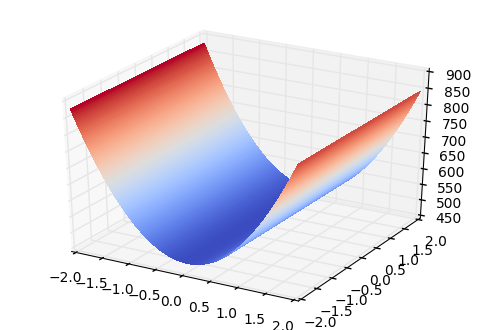

In [34]:
# Plots with 400 breaks. Breaks with 500 or more might slow the system down
surfaceErrorPlot(lp1,input_matrix = train, target_vector=trainOutput, breaks = 400)

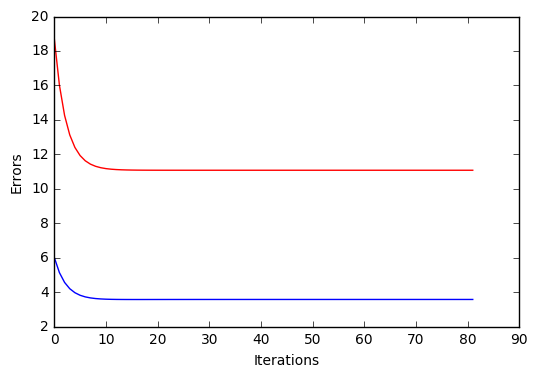

In [255]:
iterationErrorPlot(trainedPerceptron=lp1,testInput=test,testOutput=testOutput)